In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [392]:
# 加载数据
file_path = "./TrainDataset2024.xls"  # 数据文件路径
data = pd.read_excel(file_path)

# 检查数据基本信息
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.2+ KB
None
       pCR (outcome)  RelapseFreeSurvival (outcome)         Age          ER  \
count     400.000000                     400.000000  400.000000  400.000000   
mean       12.697500                      56.000208   51.804674    0.547500   
std       111.107417                      27.137584   10.948522    0.498362   
min         0.000000                       0.000000   23.000000    0.000000   
25%         0.000000                      38.000000   44.516769    0.000000   
50%         0.000000                      55.000000   51.019507    1.000000   
75%         0.000000                      73.000000   60.000000    1.000000   
max       999.000000                     144.000000   79.603012    1.000000   

              PgR        HER2  TrippleNegative  ChemoGrade  Proliferation  \
count  400.0000

In [393]:
# Step 1: 缺失值处理
# 替换 999 为 NaN
data.replace(999, np.nan, inplace=True)

# 查看缺失值情况
print(data.isnull().sum())

# 对于分类变量，用众数填充
categorical_features = ['ER', 'HER2', 'Gene', 'TrippleNegative', 'HistologyType']
for col in categorical_features:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    data[col] = imputer_cat.fit_transform(data[[col]])

ID                               0
pCR (outcome)                    5
RelapseFreeSurvival (outcome)    0
Age                              0
ER                               0
                                ..
original_ngtdm_Busyness          0
original_ngtdm_Coarseness        0
original_ngtdm_Complexity        0
original_ngtdm_Contrast          0
original_ngtdm_Strength          0
Length: 121, dtype: int64


In [394]:
# Check imbalance 
print(f"Ratio of '1' in pCR is {(data['pCR (outcome)']==1).sum() / data['pCR (outcome)'].count()}")
# This Indicate imbalance exsists, potential optimize point

Ratio of '1' in pCR is 0.21265822784810126


In [395]:
# 对于数值变量，用中位数填充
numerical_features = [col for col in data.columns if col not in categorical_features + ['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)']]
imputer_num = SimpleImputer(strategy='median')
data[numerical_features] = imputer_num.fit_transform(data[numerical_features])

# Step 2: 异常值检测和处理
# 使用箱线图法检测异常值（示例以 Tumour Proliferation 为例）
for col in numerical_features:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # 替换异常值为边界值
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])


In [396]:
# Step 3: 数据归一化
# 选择需要归一化的列（通常是数值型特征）
scaler = MinMaxScaler()  # 或者使用 StandardScaler
data[numerical_features] = scaler.fit_transform(data[numerical_features])


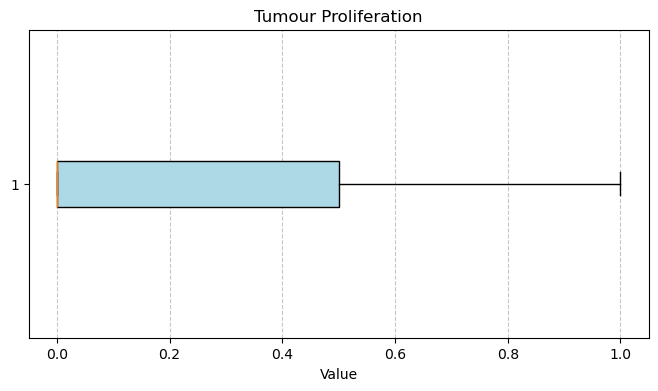

In [397]:
plt.figure(figsize=(8, 4))
plt.boxplot(data['Proliferation'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Tumour Proliferation')
plt.xlabel('Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

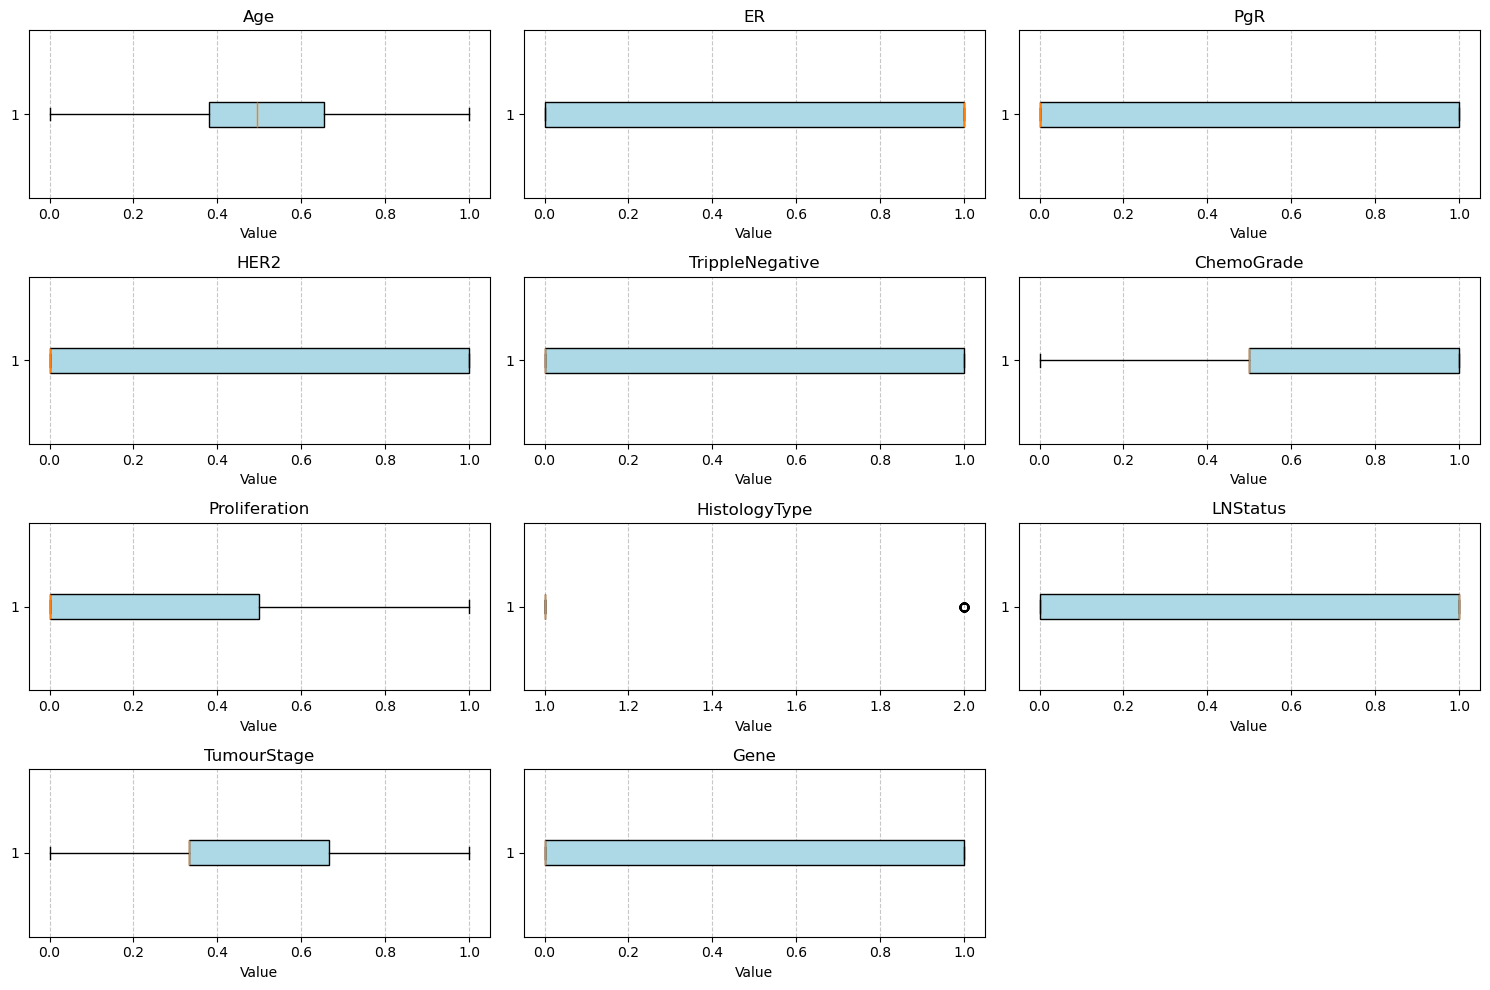

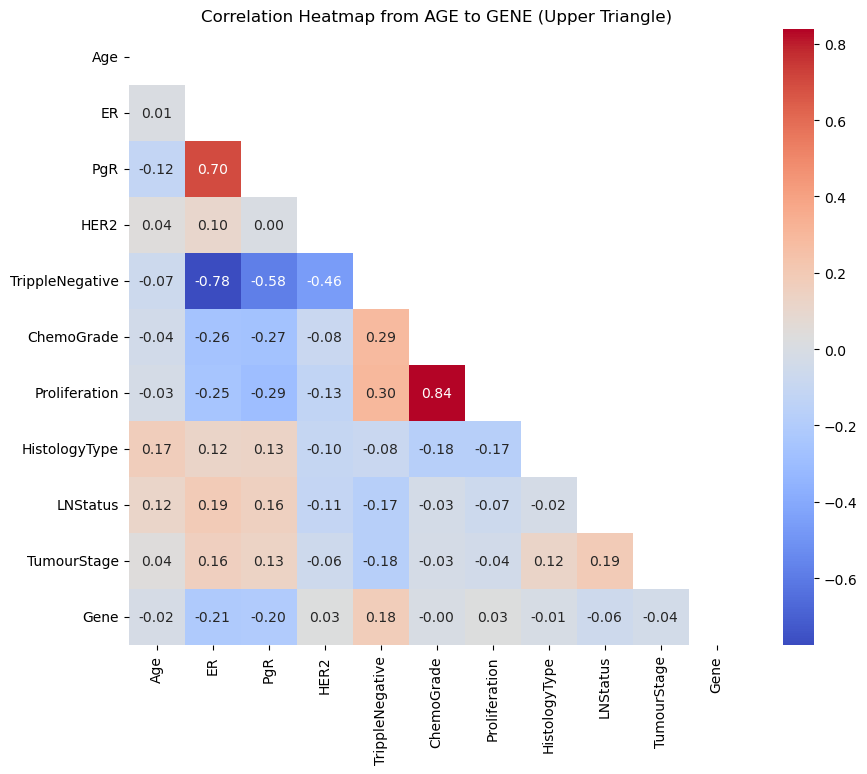

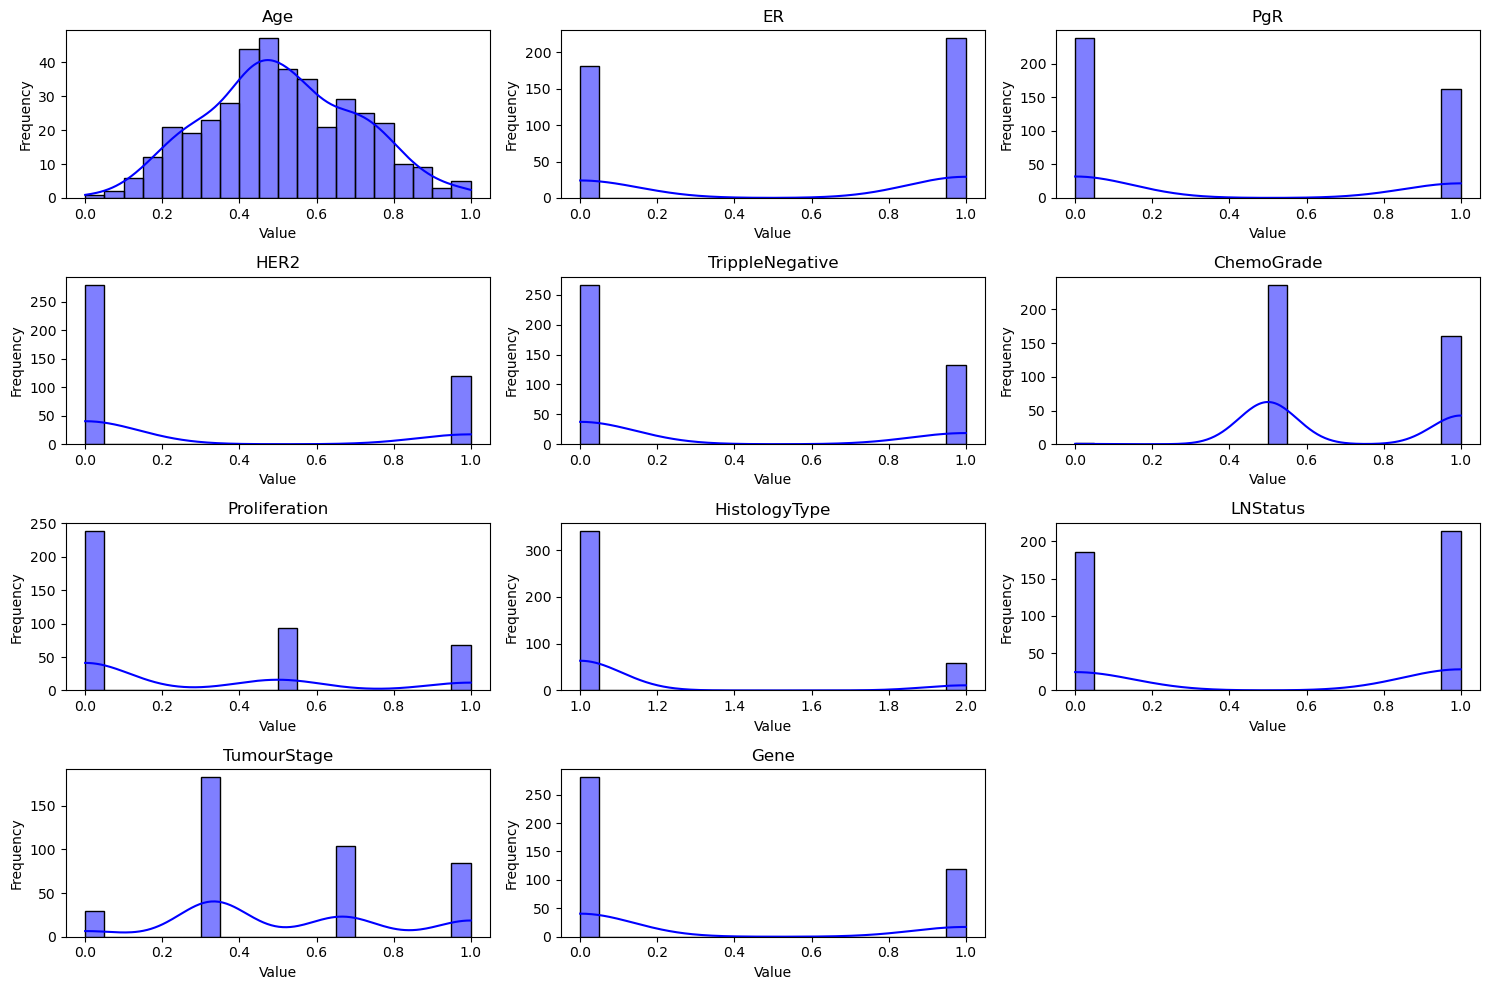

In [398]:
# 选择 AGE 到 GENE 的列
selected_columns = data.loc[:, 'Age':'Gene']

# Step 1: 绘制箱线图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    plt.boxplot(selected_columns[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(col)
    plt.xlabel('Value')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Step 2: 绘制相关性热图
# 计算相关性矩阵
corr_matrix = selected_columns.corr()

# 使用 Seaborn 绘制热成像分布图

plt.figure(figsize=(10, 8))

# 创建掩码
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 使用 Seaborn 绘制热成像分布图（仅上三角）
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Correlation Heatmap from AGE to GENE (Upper Triangle)")

plt.show()

# Step 3: 绘制直方图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    sns.histplot(selected_columns[col], kde=True, color='blue', bins=20)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [399]:
# Step 4: 数据划分
# 提取特征和目标变量
X = data.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)'])  # 去除 ID 和目标列
X_pCr = data[data['pCR (outcome)'].isin([0, 1])]
X_pCr = X_pCr.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)']) 

# 分类任务目标
# remove when pCR is absent and pCR is target
y_pcr = data[data['pCR (outcome)'].isin([0, 1])]
y_pcr = y_pcr['pCR (outcome)']
y_rfs = data['RelapseFreeSurvival (outcome)']  # 回归任务目标

In [400]:
print(y_pcr)
(y_pcr==999).sum()

0      1.0
1      0.0
2      1.0
3      0.0
4      0.0
      ... 
395    0.0
396    0.0
397    0.0
398    0.0
399    0.0
Name: pCR (outcome), Length: 395, dtype: float64


np.int64(0)

In [401]:
print(y_rfs)

0      144.000000
1      142.000000
2      135.000000
3       12.000000
4      109.000000
          ...    
395     54.500000
396     49.250000
397     48.500000
398     47.500000
399     46.916667
Name: RelapseFreeSurvival (outcome), Length: 400, dtype: float64


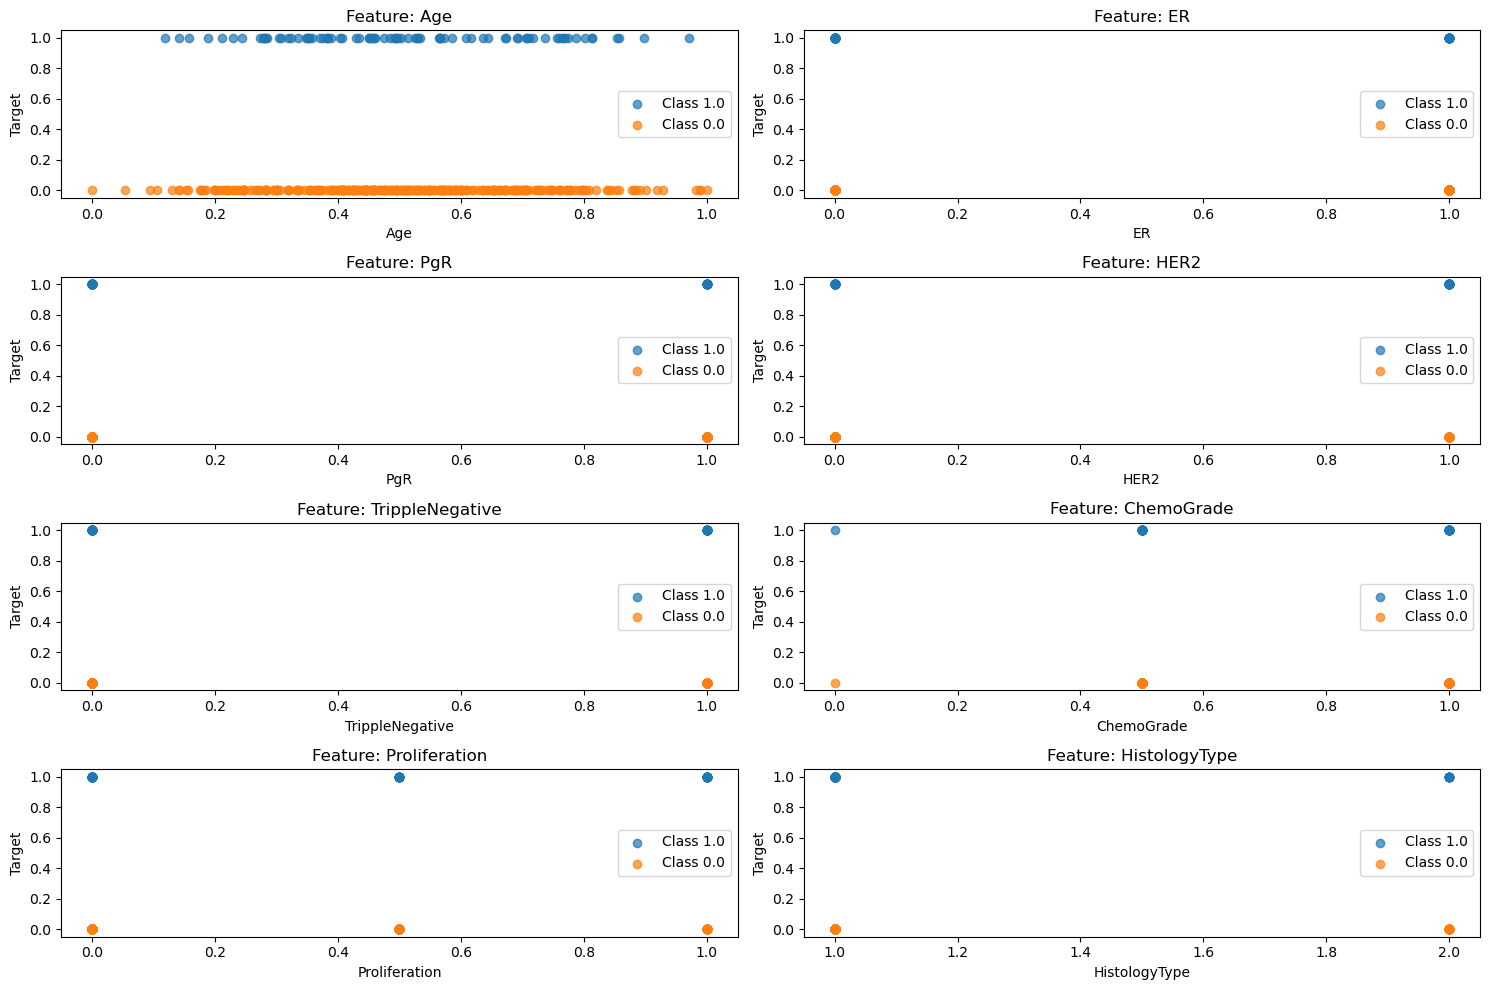

In [402]:
import matplotlib.pyplot as plt

# Step 1: Select the first 8 features
selected_features = X_pCr.columns[:8]

# Step 2: Plot settings
num_features = len(selected_features)
plt.figure(figsize=(15, 10))

# Step 3: Create scatter plots for first 8 features
for i, feature in enumerate(selected_features):
    plt.subplot((num_features + 1) // 2, 2, i + 1)  # Create a grid layout
    for target_class in y_pcr.unique():
        plt.scatter(
            X_pCr[y_pcr == target_class][feature], 
            [target_class] * len(X_pCr[y_pcr == target_class][feature]), 
            label=f"Class {target_class}", 
            alpha=0.7
        )
    plt.title(f"Feature: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Target")
    plt.legend()

plt.tight_layout()
plt.show()

In [403]:
# 按 8:2 分层划分训练集和验证集
X_train_pcr, X_val_pcr, y_train_pcr, y_val_pcr = train_test_split(
    X_pCr, y_pcr, test_size=0.2, random_state=42, stratify=y_pcr
)
X_train_rfs, X_val_rfs, y_train_rfs, y_val_rfs = train_test_split(
    X, y_rfs, test_size=0.2, random_state=42
)


In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pcr, y_train_pcr)
print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


Class distribution after SMOTE: [249 249]


C:\Users\22519\AppData\Local\Temp\ipykernel_79996\1401299204.py:7: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


In [405]:
# Step 5: 检查处理结果
print("训练集和验证集的大小：")
print("PCR 训练集:", X_train_resampled.shape, "验证集:", X_val_pcr.shape)
print("RFS 训练集:", X_train_rfs.shape, "验证集:", X_val_rfs.shape)

训练集和验证集的大小：
PCR 训练集: (498, 118) 验证集: (79, 118)
RFS 训练集: (320, 118) 验证集: (80, 118)


In [406]:
# pCR Baseline Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Model 1: LogisticRegression
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_resampled, y_train_resampled)
logistic_y_pred = logistic_model.predict(X_val_pcr)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, logistic_y_pred))

# Model 2: RandomForestClassifier
random_model = RandomForestClassifier(random_state=42)
random_model.fit(X_train_resampled, y_train_resampled)
random_y_pred = random_model.predict(X_val_pcr)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val_pcr, random_y_pred))


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.68      0.76        62
         1.0       0.33      0.59      0.43        17

    accuracy                           0.66        79
   macro avg       0.60      0.63      0.59        79
weighted avg       0.74      0.66      0.69        79


Random Forest- Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.87        62
         1.0       0.50      0.24      0.32        17

    accuracy                           0.78        79
   macro avg       0.66      0.59      0.60        79
weighted avg       0.75      0.78      0.75        79



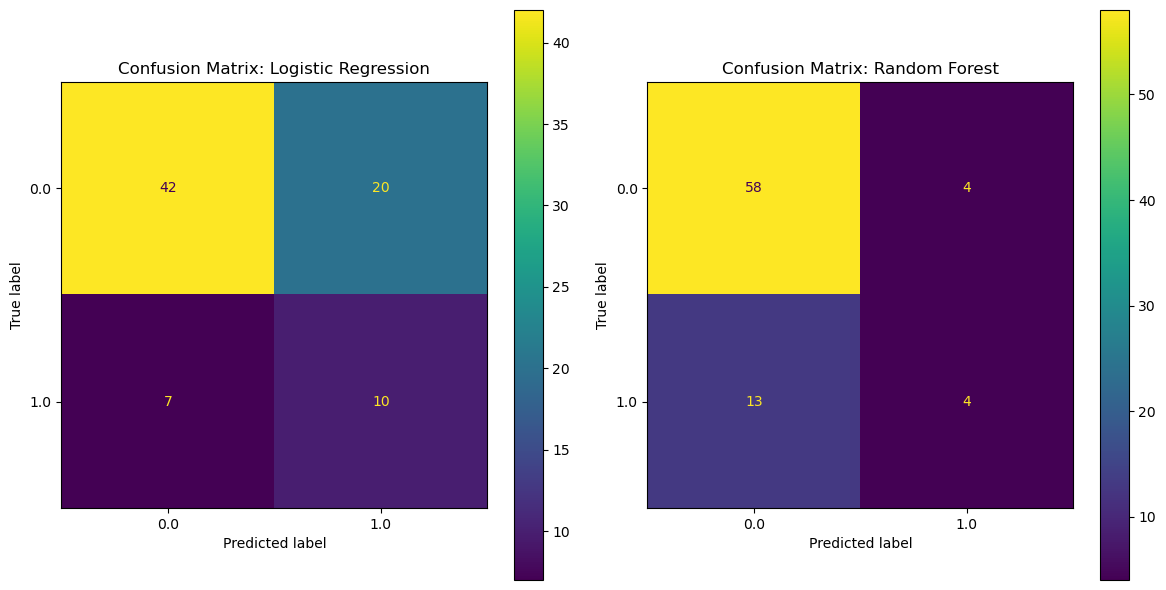

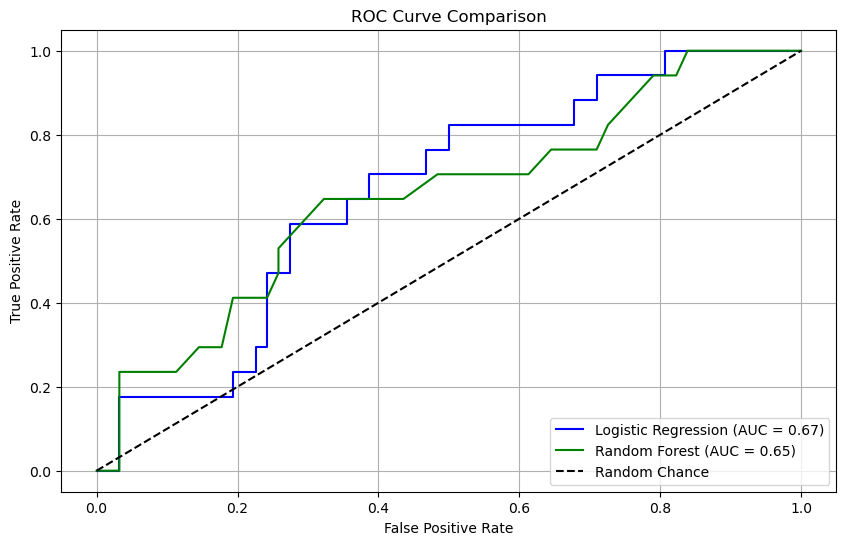

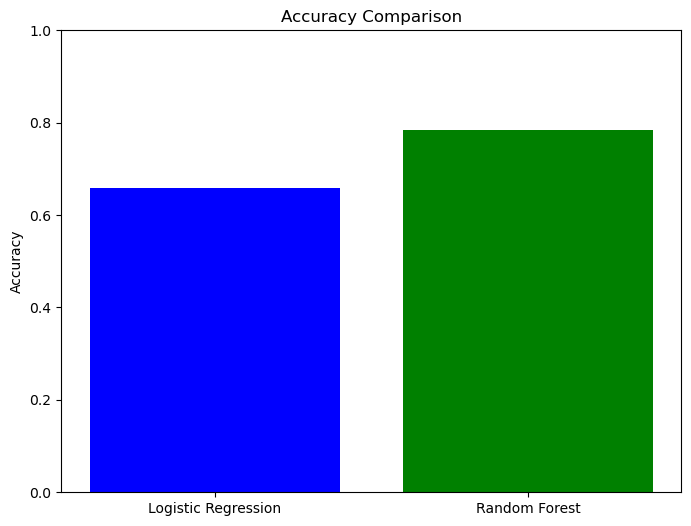

In [407]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, accuracy_score

# Step 1: Predictions and Probabilities for Logistic Regression
logistic_y_prob = logistic_model.predict_proba(X_val_pcr)[:, 1]  # Probabilities for ROC
logistic_accuracy = accuracy_score(y_val_pcr, logistic_y_pred)

# Step 2: Predictions and Probabilities for Random Forest
random_y_prob = random_model.predict_proba(X_val_pcr)[:, 1]  # Probabilities for ROC
random_accuracy = accuracy_score(y_val_pcr, random_y_pred)

# Step 3: Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_val_pcr, logistic_y_pred, ax=ax[0])
ax[0].set_title('Confusion Matrix: Logistic Regression')

ConfusionMatrixDisplay.from_predictions(y_val_pcr, random_y_pred, ax=ax[1])
ax[1].set_title('Confusion Matrix: Random Forest')

plt.tight_layout()
plt.show()

# Step 4: ROC Curves
logistic_fpr, logistic_tpr, _ = roc_curve(y_val_pcr, logistic_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_val_pcr, random_y_prob)

logistic_auc = auc(logistic_fpr, logistic_tpr)
random_auc = auc(random_fpr, random_tpr)

plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})', color='blue')
plt.plot(random_fpr, random_tpr, label=f'Random Forest (AUC = {random_auc:.2f})', color='green')

# Diagonal for random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Plot settings
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 5: Bar Chart for Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Logistic Regression', 'Random Forest'], [logistic_accuracy, random_accuracy], color=['blue', 'green'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()
